<a href="https://colab.research.google.com/github/amrios80/MINE_4210_ADL_202520/blob/main/labs/Laboratorio_3/MINE__4210_ADL_202520_L3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Logo ADL](https://github.com/nicolastibata/MINE_4210_ADL_202520/blob/main/docs/images/logo.png?raw=true)


# **Laboratorio 3: Redes CNN para clasificación de imágenes**
**Tutor: Nicolás Tibatá**

## **Tabla de Contenido**

[Contexto y objetivos](#scrollTo=5KnQpgpopi8a)<br>
[1. Introducción de los datos](#scrollTo=VjA8zwzJvmeO)<br>
[2. Preparación y Modelamiento](#scrollTo=kG8XHROzvuEH)<br>
[3. Preguntas](#scrollTo=JTKc52_Wvs_N)<br>

### **Contexto y Objetivos**

**Problema**
- En este problema se busca clasificar imágenes del lenguaje de señas, haciendo uso de redes convolucionales.

**Objetivos**
1. Entender los fundamentos y la arquitectura de las redes neuronales convolucionales (CNN).
2. Implementar una red convolucional simple para tareas de clasificación de imágenes.
3. Conocer el funcionamiento de capas clave: Conv2D, Pooling, Dropout, Flatten y Dense.
4. Entrenar y evaluar el modelo, analizando el impacto de cada componente.


**Datos**

Los datos los puedes consultar [aquí](https://www.kaggle.com/datasets/ayuraj/asl-dataset).

### **1. Introducción a los datos**

In [1]:
# Instalación e Importación de librerías
!pip install keras-tuner -q
!pip install scikit-learn -q
!pip install tensorflow -q

import os
import json
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import userdata

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.0 MB/s eta 0:00:00


In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"adrianamariarios","key":"636170a31f11fe8cb07f3204ae8200b7"}'}

In [6]:
import os
import shutil

os.makedirs('/root/.kaggle', exist_ok=True)

# Mover kaggle.json al directorio .kaggle
shutil.move('kaggle.json', '/root/.kaggle/kaggle.json')

# Dar permisos correctos
os.chmod('/root/.kaggle/kaggle.json', 600)

In [13]:
#os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
#os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

from google.colab import userdata
userdata.get('adrianamariarios')

!kaggle datasets download -d ayuraj/asl-dataset

! unzip "asl-dataset.zip"

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: asl_dataset/0/hand2_0_dif_seg_1_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0_dif_seg_2_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0_dif_seg_3_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0_dif_seg_4_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0_dif_seg_5_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0_left_seg_1_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0_left_seg_2_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0_left_seg_3_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0_left_seg_4_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0_left_seg_5_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0_right_seg_1_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0_right_seg_2_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0_right_seg_3_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0_right_seg_4_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0_right_seg_5_cropped.jpeg  
  inflating: asl_dataset

In [14]:
# Need to eliminate folder with content
shutil.rmtree('/content/asl_dataset/asl_dataset')

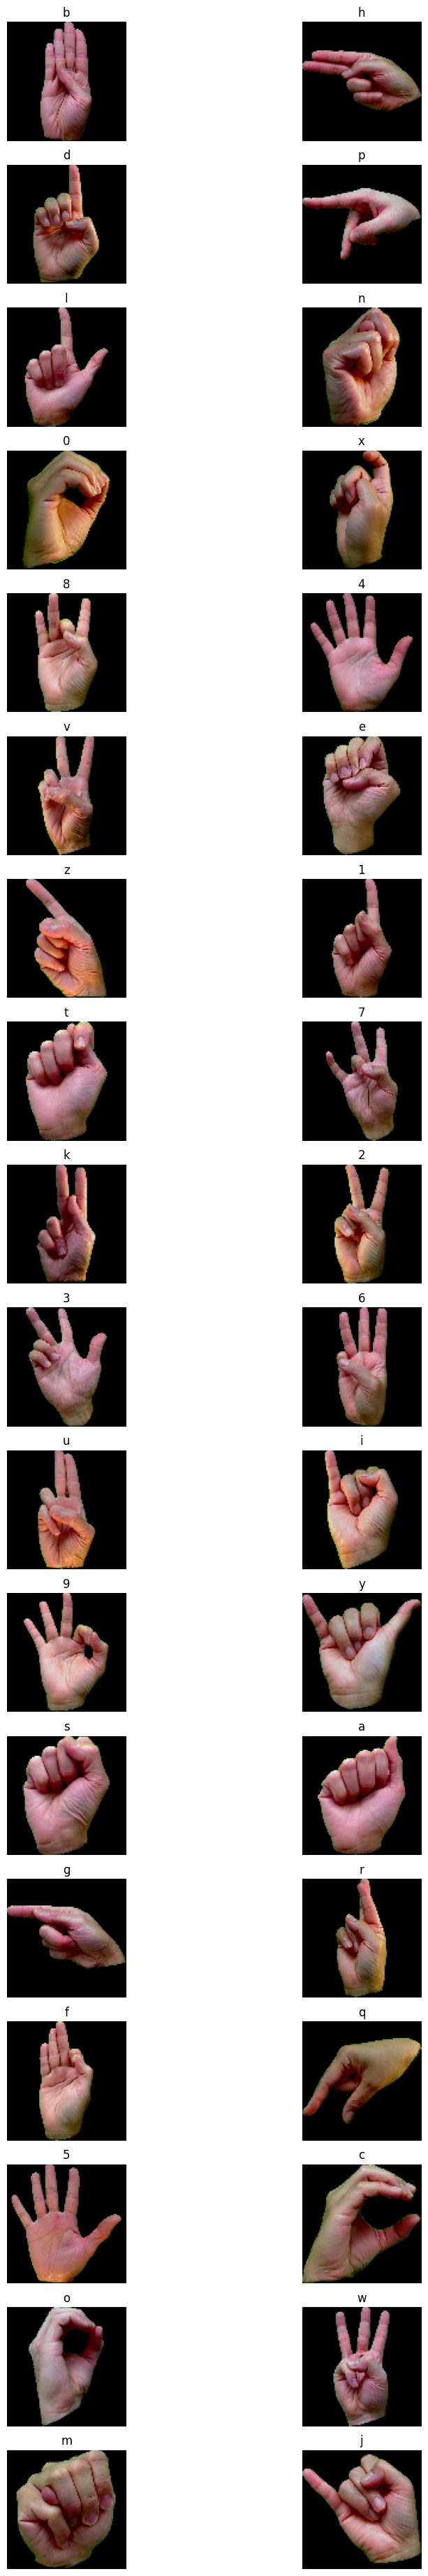

Total de imágenes: 2515
Número de imágenes por categoría:
b: 70
h: 70
d: 70
p: 70
l: 70
n: 70
0: 70
x: 70
8: 70
4: 70
v: 70
e: 70
z: 70
1: 70
t: 65
7: 70
k: 70
2: 70
3: 70
6: 70
u: 70
i: 70
9: 70
y: 70
s: 70
a: 70
g: 70
r: 70
f: 70
q: 70
5: 70
c: 70
o: 70
w: 70
m: 70
j: 70


In [15]:
# Directorio de datos y obtención de las categorías
data_dir = '/content/asl_dataset'
asl_categories = os.listdir(data_dir)

# Visualización de una imagen de cada categoría
plt.figure(figsize=(10, 50))
for i, category in enumerate(asl_categories):
    folder = os.path.join(data_dir, category)
    image_file = os.listdir(folder)[0]
    img_path = os.path.join(folder, image_file)
    img = keras.preprocessing.image.load_img(img_path, target_size=(100, 100))
    plt.subplot(int(len(asl_categories)/2) + 1, 2, i+1)
    plt.title(category)
    plt.imshow(img)
    plt.axis('off')
plt.show()

# Análisis del tamaño y distribución de clases
image_count = {}
total_images = 0
for category in asl_categories:
    folder = os.path.join(data_dir, category)
    count = len(os.listdir(folder))
    image_count[category] = count
    total_images += count

print(f"Total de imágenes: {total_images}")
print("Número de imágenes por categoría:")
for category, count in image_count.items():
    print(f"{category}: {count}")

Podemos darnos cuenta que son imágenes separadas por cada letra del abecedario en lenguaje de señas, cada letra y número contiene alrededor de 70 registros fotográficos.

### **2. Preparación y Modelamiento**

#### **Preparación**

Se crea un DataFrame con las rutas de los archivos y sus etiquetas (la etiqueta se infiere del nombre de la carpeta). Luego, se dividen los datos en conjuntos de entrenamiento, validación y test.

**Nota:** En este laboratorio no se aplican transformaciones complejas (como ecualización de histograma o filtros), sino que solo se reescala la imagen.

In [ ]:
# Recopilación de rutas y etiquetas
filepaths = [os.path.join(dp, f) for dp, dn, filenames in os.walk(data_dir)
             for f in filenames if os.path.splitext(f)[1].lower() in ['.png','.jpg','.jpeg']]
labels = [os.path.split(os.path.split(path)[0])[1] for path in filepaths]

# Crear DataFrame
data_df = pd.DataFrame({'filepath': filepaths, 'label': labels})

# Dividir en entrenamiento (70%), validación (20%) y test (10%)
train_df, test_val_df = train_test_split(data_df, test_size=0.3, random_state=13)
test_df, val_df = train_test_split(test_val_df, test_size=2/3, random_state=13)

print("Total de imágenes:", len(data_df))
print("Entrenamiento:", len(train_df))
print("Validación:", len(val_df))
print("Test:", len(test_df))

Total de imágenes: 2515
Entrenamiento: 1760
Validación: 504
Test: 251


Se utilizan los generadores de datos de Keras para cargar las imágenes en tiempo real.

- Para el conjunto de entrenamiento se aplica data augmentation (rotación, volteo) para mejorar la robustez del modelo.
- Para validación y test, solo se reescala la imagen.

In [ ]:
# Generador para entrenamiento con data augmentation
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True
)

# Generador para validación y test (solo reescala)
test_val_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Creación de generadores a partir de los DataFrames
train_gen = train_datagen.flow_from_dataframe(
    train_df, x_col='filepath', y_col='label',
    target_size=(100, 100), batch_size=32
)
val_gen = test_val_datagen.flow_from_dataframe(
    val_df, x_col='filepath', y_col='label',
    target_size=(100, 100), batch_size=32, shuffle=False
)
test_gen = test_val_datagen.flow_from_dataframe(
    test_df, x_col='filepath', y_col='label',
    target_size=(100, 100), batch_size=32, shuffle=False
)

Found 1760 validated image filenames belonging to 36 classes.
Found 504 validated image filenames belonging to 36 classes.
Found 251 validated image filenames belonging to 36 classes.


#### **Modelamiento**

Se implementa una red neuronal convolucional simple con las siguientes capas:

- **Conv2D:** Aplica filtros aprendibles para extraer características de la imagen.
- **Pooling (MaxPooling2D):** Reduce la dimensión espacial, ayudando a la invariancia a traslaciones y reduciendo el cómputo. Existen otros tipos de pooling que también pueden implementar en la arquitectura como AveragePooling2D, GlobalMaxPooling2D y GlobalAveragePooling2D.
- **Flatten:** Convierte la salida multidimensional en un vector unidimensional.
- **Dense:** Capas completamente conectadas para la clasificación.
- **Dropout:** Regularización para prevenir el sobreajuste.

Cada componente se explica en el código para facilitar su comprensión.

In [ ]:
# Construcción del modelo CNN
model = Sequential([
    # Primera capa convolucional: extrae características básicas
    Conv2D(16, (3, 3), activation='relu', input_shape=(100, 100, 3)),
    MaxPooling2D((2, 2)),

    # Segunda capa convolucional: extrae características más complejas
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Aplanamiento para conectar con las capas densas
    Flatten(),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(len(asl_categories), activation='softmax')  # Capa de salida para clasificación
])

# Resumen del modelo para verificar la arquitectura
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 47, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16928)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │       270,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 36)             │           612 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 276,564 (1.06 MB)

 Trainable params: 276,564 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

Se compila el modelo definiendo el optimizador, la función de pérdida y la métrica de evaluación. Utilizamos el optimizador **adam** y la función de pérdida **categorical_crossentropy** adecuada para clasificación multiclase.

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Además vamos a aplicar **callbacks** dentro del entrenamiento:
- **ModelCheckpoint:** Guardar el modelo que presente la menor pérdida en validación.
- **EarlyStopping:** Detener el entrenamiento si la métrica de validación no mejora.
- **ReduceLROnPlateau:** Reducir la tasa de aprendizaje cuando la métrica se estabiliza.

In [ ]:
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True,
                                   monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='min')

callbacks = [model_checkpoint, early_stopping, reduce_lr]

Por último, entrenamos la red convolucional utilizando el conjunto de entrenamiento y se valida con el de validación. Se recomienda experimentar modificando el número de épocas para observar el comportamiento del entrenamiento.

In [ ]:
%%time
with tf.device('/device:GPU:0'):
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=50,
        callbacks=callbacks
    )

Epoch 1/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - accuracy: 0.6306 - loss: 1.0745 - val_accuracy: 0.8532 - val_loss: 0.4873 - learning_rate: 0.0010
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 0.6167 - loss: 1.0923 - val_accuracy: 0.8492 - val_loss: 0.4927 - learning_rate: 0.0010
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - accuracy: 0.6322 - loss: 1.0852 - val_accuracy: 0.8611 - val_loss: 0.4745 - learning_rate: 0.0010
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 0.6233 - loss: 1.0950 - val_accuracy: 0.8730 - val_loss: 0.4414 - learning_rate: 0.0010
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - accuracy: 0.6410 - loss: 1.0564 - val_accuracy: 0.8472 - val_loss: 0.4644 - learning_rate: 0.0010
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - accuracy: 0.6378 - loss: 1.0214 - val_accuracy: 0.8552 - val_loss: 0.4590 - learning_rate: 0.0010
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - accuracy: 0.6443 - loss: 1.0171 - 

Ahora revisemos el **desempeño** de nuestro modelo:

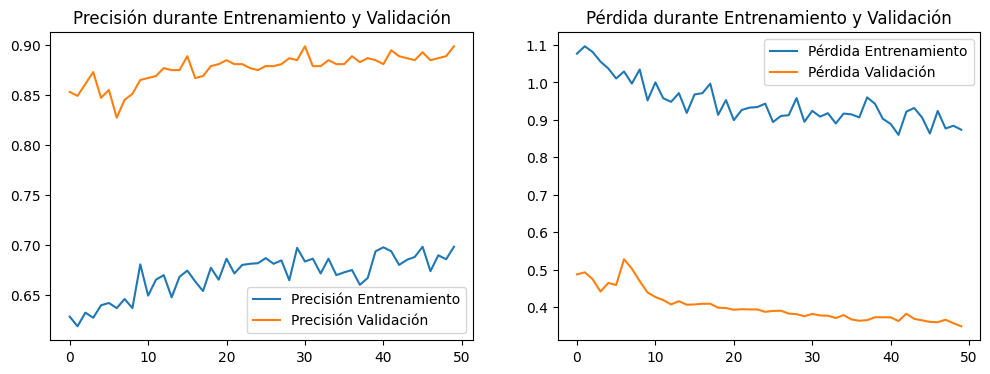

In [ ]:
# Visualización de la evolución del entrenamiento
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Precisión Entrenamiento')
plt.plot(epochs_range, val_acc, label='Precisión Validación')
plt.legend(loc='lower right')
plt.title('Precisión durante Entrenamiento y Validación')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Pérdida Entrenamiento')
plt.plot(epochs_range, val_loss, label='Pérdida Validación')
plt.legend(loc='upper right')
plt.title('Pérdida durante Entrenamiento y Validación')
plt.show()

Ahora si **evaluemos** el modelo

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step


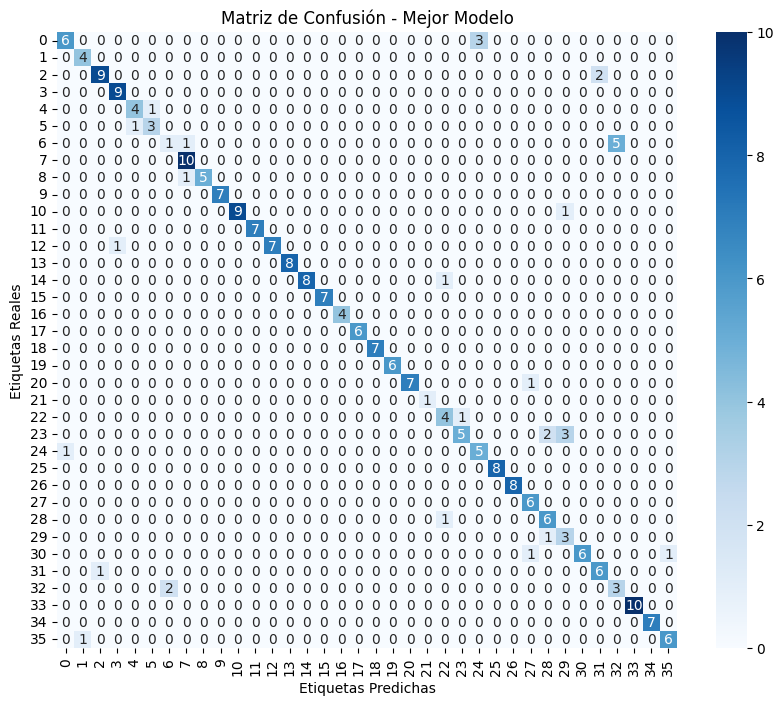

              precision    recall  f1-score   support

           b       0.86      0.67      0.75         9
           q       0.80      1.00      0.89         4
           d       0.90      0.82      0.86        11
           t       0.90      1.00      0.95         9
           i       0.80      0.80      0.80         5
           e       0.75      0.75      0.75         4
           c       0.33      0.14      0.20         7
           l       0.83      1.00      0.91        10
           5       1.00      0.83      0.91         6
           r       1.00      1.00      1.00         7
           h       1.00      0.90      0.95        10
           k       1.00      1.00      1.00         7
           z       1.00      0.88      0.93         8
           3       1.00      1.00      1.00         8
           a       1.00      0.89      0.94         9
           m       1.00      1.00      1.00         7
           7       1.00      1.00      1.00         4
           p       1.00    

In [ ]:
# Cargar el modelo guardado con el mejor desempeño en validación
best_model = load_model('best_model.keras')

# Evaluar el modelo en el conjunto de test
test_gen.reset()
predicciones = best_model.predict(test_gen, verbose=1)
y_pred = np.argmax(predicciones, axis=1)
y_test = test_gen.classes

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues)
plt.title('Matriz de Confusión - Mejor Modelo')
plt.ylabel('Etiquetas Reales')
plt.xlabel('Etiquetas Predichas')
plt.show()

print(classification_report(y_test, y_pred, target_names=asl_categories, zero_division=0))

### **3. Preguntas**

1. ¿Cómo afecta el tamaño del filtro en las capas convolucionales al rendimiento del modelo? Analiza y experimenta cómo el tamaño del filtro influye en la capacidad del modelo para capturar características.
-

2. ¿Qué ventajas y desventajas presentan las diferentes estrategias de pooling (MaxPooling, AveragePooling, GlobalPooling) en la extracción de características?
-

3. ¿Qué impacto tiene el uso de técnicas como Dropout o Batch Normalization en el entrenamiento de redes convolucionales? ¿Cómo contribuye a la estabilidad del entrenamiento y la mejora del rendimiento del modelo?
-